In [39]:
import nn_pruning.examples.question_answering.qa_sparse_xp as qa_sparse_xp
from pathlib import Path
import shutil

path = "/data_2to/devel_data/nn_pruning/output/squad_test_aws/aws_nn-pruning-v8-a16-l10--2021-01-19--16-57-25/checkpoint-110000/"
path = "/data_2to/devel_data/nn_pruning/output/squad_test3/hp_od-output__squad_test3_es-steps_nte20_ls250_stl50_est5000_rn-output__squad_test3_dpm-sigmoied_threshold_apme-sigmoied_threshold_aowd0_bm1_dbr32_dbc32_abr32_abc32_it0_fw10_r-l1_rfl30_dtnop-csarron__bert-base-uncased-squad-v1/checkpoint-110000/"
path = "/data_2to/devel_data/nn_pruning/output/squad_test_aws/aws_nn-pruning-v8-a8-l20--2021-01-19--16-59-13/checkpoint-110660/"
path = Path(path)
dest_path = Path("/tmp/compiled_model")

if dest_path.exists():
    shutil.rmtree(dest_path)
    
dest_path.mkdir()    
    
qa_sparse_xp.QASparseXP.compile_model(path, dest_path = dest_path)

Some weights of the model checkpoint at /data_2to/devel_data/nn_pruning/output/squad_test_aws/aws_nn-pruning-v8-a8-l20--2021-01-19--16-59-13/checkpoint-110660 were not used when initializing BertForQuestionAnswering: ['bert.encoder.layer.0.attention.self.query.mask_module.context_modules.0.mask_scores', 'bert.encoder.layer.0.attention.self.key.mask_module.context_modules.0.mask_scores', 'bert.encoder.layer.0.attention.self.value.mask_module.context_modules.0.mask_scores', 'bert.encoder.layer.0.attention.output.dense.mask_module.context_modules.0.mask_scores', 'bert.encoder.layer.0.intermediate.dense.mask_module.context_modules.0.mask_scores', 'bert.encoder.layer.0.output.dense.mask_module.context_modules.0.mask_scores', 'bert.encoder.layer.1.attention.self.query.mask_module.context_modules.0.mask_scores', 'bert.encoder.layer.1.attention.self.key.mask_module.context_modules.0.mask_scores', 'bert.encoder.layer.1.attention.self.value.mask_module.context_modules.0.mask_scores', 'bert.encod

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [40]:
import torch

m = torch.load(dest_path / "pytorch_model.bin")


<ipython-input-41-48933c5815ad>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


5.916666666666667


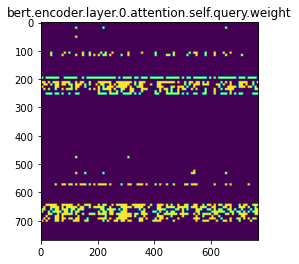

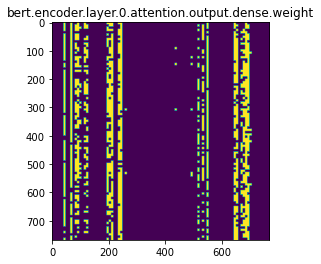

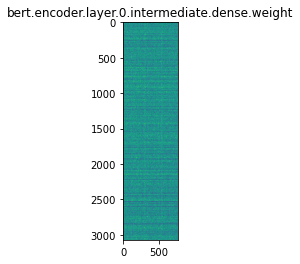

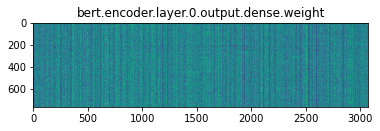

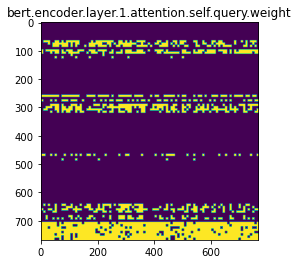

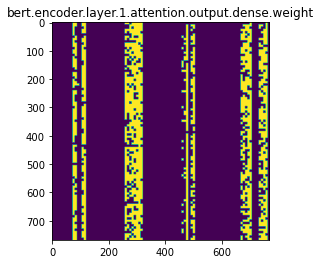

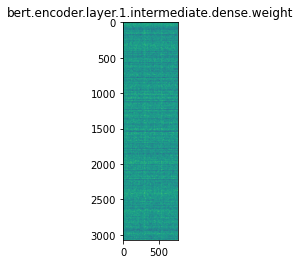

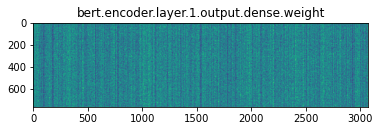

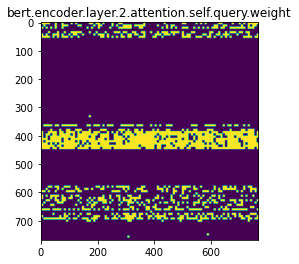

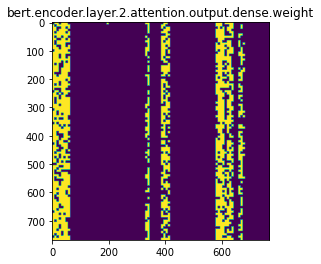

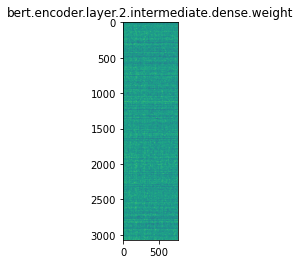

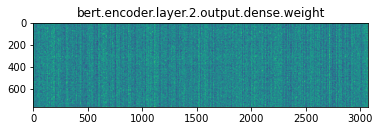

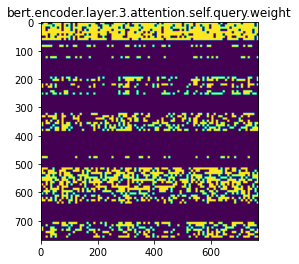

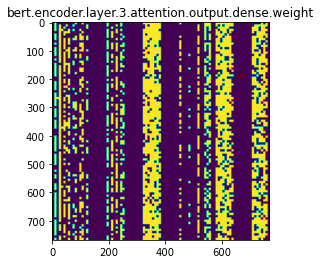

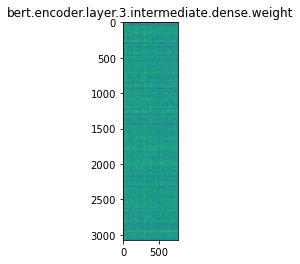

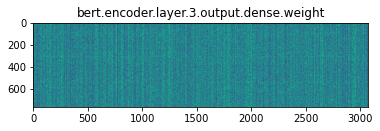

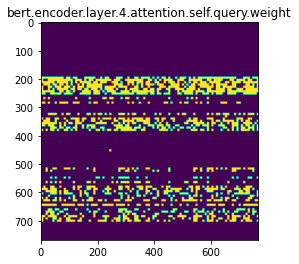

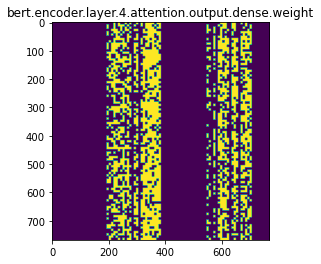

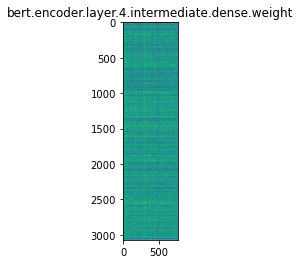

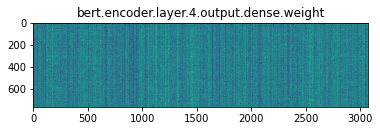

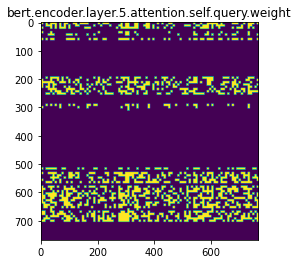

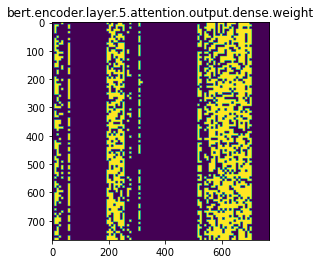

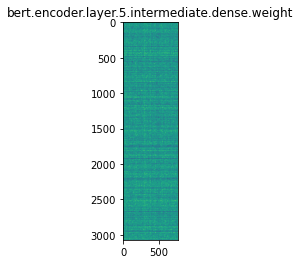

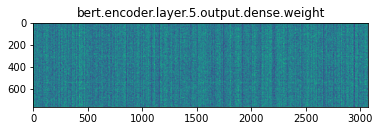

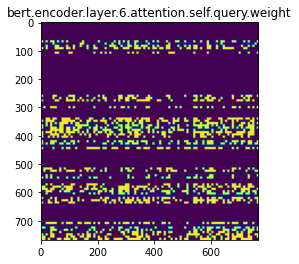

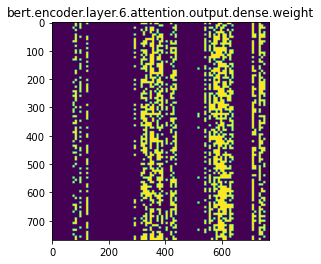

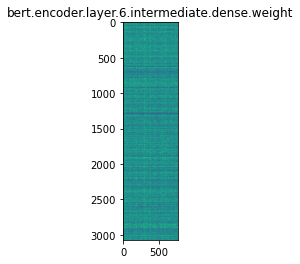

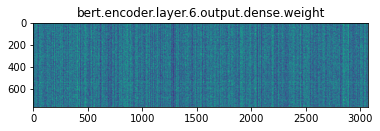

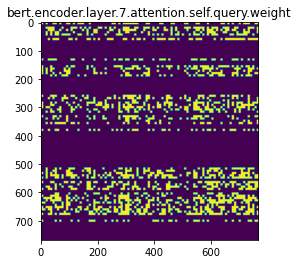

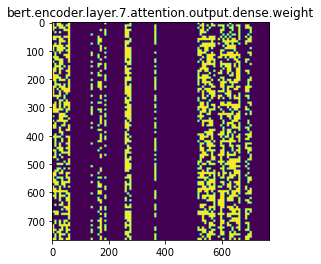

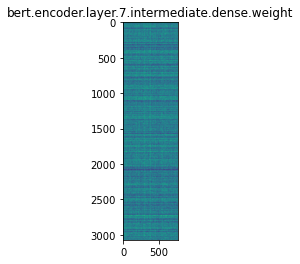

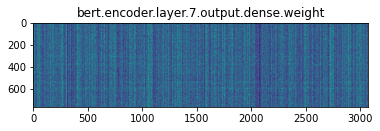

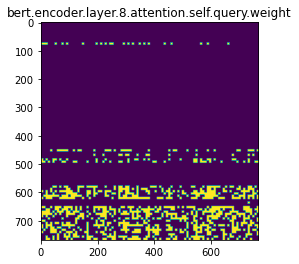

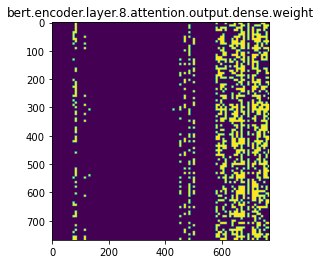

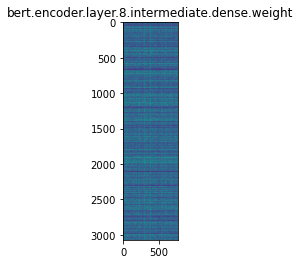

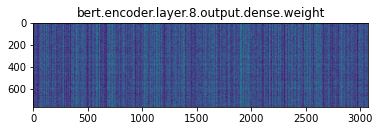

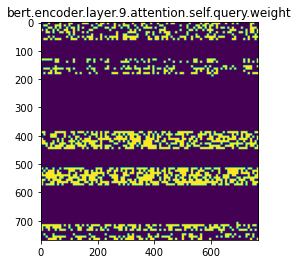

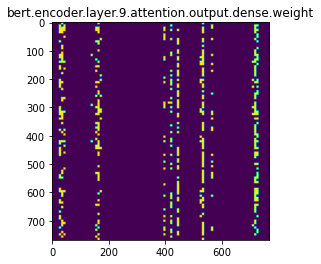

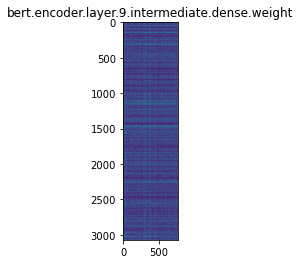

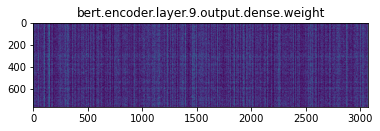

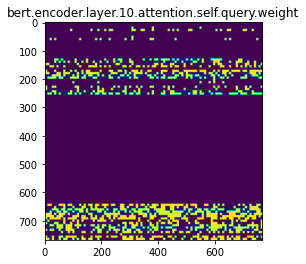

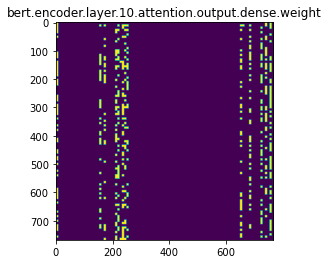

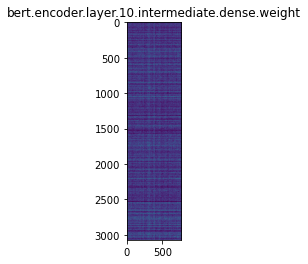

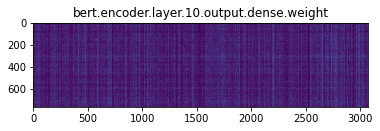

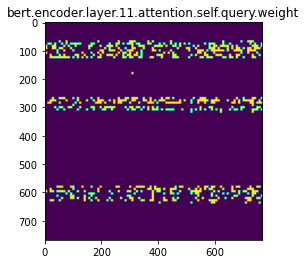

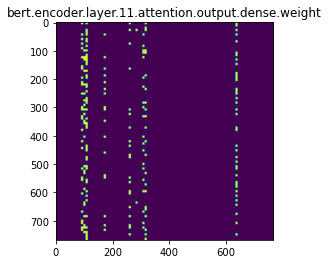

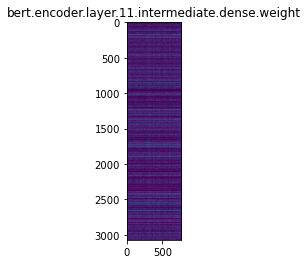

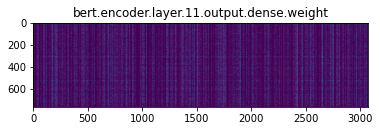

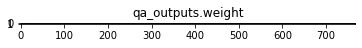

In [41]:
import torch
from matplotlib import pyplot as plt

def display(p, title=None, binary = True):
    plt.figure()
    if binary:
        p = (p != 0).cpu()
    else:
        p = p.abs().cpu()
#    print(p.max(), p.min())    
    if p.dim() == 2:
        plt.imshow(p, cmap="viridis")
    elif p.dim() == 1:
        plt.plot(p)
    else:
        raise RuntimeError("Bad number of dims")
        
    if title != None:
        plt.title(title)
    
def analyze(p, name):
    p = (p != 0).reshape(p.shape[0] // 32, 32, p.shape[1] // 32, 32).transpose(1,2).all(-1).all(-1)    
    
    display(p, name)
#    p = p.all(dim)
#    print(p)

def analyze_head(p, name):
    p0 = (p != 0).reshape(p.shape[0] // 64, 64, p.shape[1]).any(1).any(-1).sum()
    
    (p != 0).reshape(p.shape[0] // 64, 64, p.shape[1]).any(1).any(-1).sum()
    
    display(p, name)

    return p0.item()
    
#    p = p.all(dim)
#    print(p)

    
heads_count = 0
for p in m:
    if "weight" in p and "LayerNorm" not in p:
        names = ["query", "key", "value"]
        #print(p)
        if p.endswith(f".{names[0]}.weight"):
            head_count = analyze_head(m[p], p)
            #print(head_count)
            heads_count += head_count
            prefix = ".".join(p.split(".")[:-2])
            tensors = []
            for name in names:
                tensors.append(m[f"{prefix}.{name}.weight"])
                
            t = torch.cat(tensors, dim=1)
            #display(t)
        else:
            if not p.endswith(f".{names[1]}.weight") and not p.endswith(f".{names[2]}.weight"):
                if "embeddings" not in p:
                    display(m[p], p, binary = True)
            
            #print(p)
#        if "dense" not in p:
#            analyze_head(m[p], p)
#        break

print(heads_count / 12)

In [42]:
heads_count = 0
attention_sparsity = 0
attention_count = 0
average_sparsity = 0
average_sparsity_count = 0

for p in m:
    if "weight" in p and "LayerNorm" not in p:
         if "embeddings" not in p:
            a = m[p].abs()
            lines = a.sum(1)
            cols = a.sum(1)
            lines_s = (lines ==0).sum() / lines.numel()
            cols_s = (cols ==0).sum() / cols.numel()
            s = min(lines_s, cols_s)        
            ws = (a == 0).sum()
            average_sparsity += ws
            average_sparsity_count += a.numel()
            
            if "attention" in p:
                attention_sparsity += s
                attention_count += 1
                
                
            print(p, s, ws / a.numel())
            
    
print("attention average sparsity", attention_sparsity/attention_count)
print("average sparsity", average_sparsity/average_sparsity_count)


bert.encoder.layer.0.attention.self.query.weight tensor(0.7604) tensor(0.9155)
bert.encoder.layer.0.attention.self.key.weight tensor(0.7604) tensor(0.9020)
bert.encoder.layer.0.attention.self.value.weight tensor(0.7396) tensor(0.8575)
bert.encoder.layer.0.attention.output.dense.weight tensor(0.) tensor(0.8529)
bert.encoder.layer.0.intermediate.dense.weight tensor(0.) tensor(0.4929)
bert.encoder.layer.0.output.dense.weight tensor(0.) tensor(0.5516)
bert.encoder.layer.1.attention.self.query.weight tensor(0.6979) tensor(0.8343)
bert.encoder.layer.1.attention.self.key.weight tensor(0.6979) tensor(0.8264)
bert.encoder.layer.1.attention.self.value.weight tensor(0.7292) tensor(0.8302)
bert.encoder.layer.1.attention.output.dense.weight tensor(0.) tensor(0.8120)
bert.encoder.layer.1.intermediate.dense.weight tensor(0.) tensor(0.4696)
bert.encoder.layer.1.output.dense.weight tensor(0.) tensor(0.5499)
bert.encoder.layer.2.attention.self.query.weight tensor(0.6354) tensor(0.8423)
bert.encoder.laye